<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/08_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

##Aşama-1: Kurulum ve Güncelleme

In [1]:
# Torch'un güncel olarak torch 1.12+ ve torchvision 0.13+ versiyonlarından üstün olup olamdığına bakalım.
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version 1.12+ üstü olmalıdır!"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version 0.13+ üstü olmalıdır!"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versionları son sürümleri ile güncellenmektedir...")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versionları son sürümleri ile güncellenmektedir...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


##Kütüphaneleri Getirme

In [2]:
# Temel Kütüphaneler
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Torchinfo var mı? yoksa Yükle!
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulunamadı. Yükleniyor...")
    !pip install -q torchinfo
    from torchinfo import summary

# Module_Files dosyasındaki kütüphanelerimizi yüklemeye çalışalım.
try:
    from Module_Files import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Dosyalar bulunamadı. Github'tan dosyalara erişiliyor...")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

[INFO] Torchinfo bulunamadı. Yükleniyor...
[INFO] Dosyalar bulunamadı. Github'tan dosyalara erişiliyor...
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 139 (delta 69), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 8.94 MiB | 10.80 MiB/s, done.
Resolving deltas: 100% (69/69), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
              

### device ? cpu : gpu -> cihaza yolla

In [3]:
# device ? cpu : gpu -> cihaza yolla
device = "cuda" if torch.cuda.is_available() else "cpu"

##Aşama-2: Veri Alma Aşaması

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Dosya yolunu oluştur.
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Yoksa bir yol hazırla!
if image_path.is_dir():
    print(f"{image_path} bu yol zaten var.")
else:
    print(f"{image_path} dosya yolu bulunamadı. Bir tane oluştur...")
    image_path.mkdir(parents=True, exist_ok=True)

    # David Bourke'un oluşturduğu veri yolunu oluştur.
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Veriler indiriliyor...")
        f.write(request.content)

    # Veriler arşivden ayıklanıyor...
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Veriler arşivden ayıklanıyor...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi bu yol zaten var.


###Dosya Yolu Oluştur.

In [5]:
#Dosya yollarını sadeleştirmek için değişkene aktarma yap.
train_dir = image_path / "train"
test_dir = image_path / "test"

##DataSet ve DataLoader Oluştur.

In [6]:
# Önceden eğitilmiş veri için uygun veri sağla.
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = ImageNet için önceden eğitilmiş verilere uygun en ideal değerdir.
model = torchvision.models.efficientnet_b0(weights=weights).to(device) #Cihaza yollanacak yapı
print(model)
# Bu veri için otomatik en uygun transform oluştur.
auto_transforms = weights.transforms()

# DataLoader'ları oluşturma ve Etiketleri isimlendirme
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, #Otomatik doldurma yapılacak
                                                                               batch_size=32) # mini-batch miktarını 32 yap.

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 58.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

##Aşama-3: Eğitilmiş Modeli Alma ve Yazdırma

In [7]:
# torchinfo.summary() -> modelin durumunu anlama
summary(model=model,
        input_size=(32, 3, 224, 224), #input shape verilerini size olarak görelim.
        # col_names=["input_size"], #Daha sade sonuca ulaşmak için size'a bakıyoruz.
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [8]:
# Bazı katmanları gradyen ihtiyacını kapatarak dondurmayı başlatabiliriz.
#Feature çıkarıcının olmamasını sağlıyoruz bu yöntemle
for param in model.features.parameters():
    param.requires_grad = False

In [9]:
# Manual seed ayarlandı.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# her sınıf için bir çıktı alacak biçimde kaç sınıfın olduğunu alıyoruz.
output_shape = len(class_names)

# Classifier'ı yeniden düzenliyoruz.
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # Çıktı miktarını burada tekrar düzenliyoruz.
                    bias=True)).to(device)

# Kodumuzu güncelledikten sonra bir kez daha özeti yazdıralım.
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

#Aşama 4: Modeli Eğitme

In [10]:
#loss ve optimizer değerini ayarlama
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Seed at
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Zamanlamayı başlat.
from timeit import default_timer as timer
start_time = timer()

# Eğitimi oluştur ve sonuçları sakla
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# Zamanlamayı bitir ve çalışmayı yazdır.
end_time = timer()
print(f"[INFO] Toplam Eğitim Zamanı: {end_time-start_time:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Toplam Eğitim Zamanı: 177.935


[INFO] Couldn't find helper_functions.py, downloading...


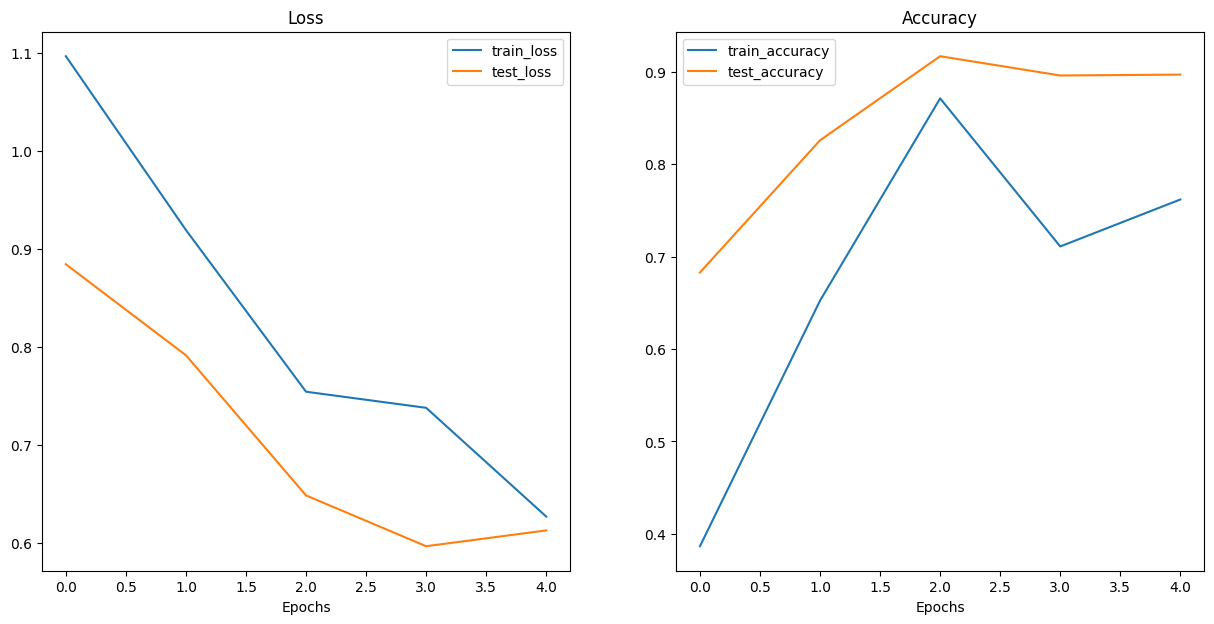

In [13]:
#Bunu daha önce yapmıştık.
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Modelin curve'lerini çizdir
plot_loss_curves(results)

#Aşama 5: Tahmin Yürütme

In [14]:
from typing import List, Tuple

from PIL import Image

# Eğitilmiş modelin parametrelerini al.
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # Resmi aç.
    img = Image.open(image_path)

    # Resmin dönüşümü sağlanmamışsa sağla.
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # Device'a resmi yönlendireceğiz
    model.to(device)

    # Eval modunu başlat.
    model.eval()
    with torch.inference_mode():
      #Ekstra boyutlar ekleniyor (batchsize, color, height,width)
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # Ekstra boyutlarla birlite araca yolla.
      target_image_pred = model(transformed_image.to(device))

    #Logaritmaları olasılığa çevir (torch.softmax() -> multi-class)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Olasılıkları tahmin etiketlerine çevir.
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Sonuçları görselleştir.
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

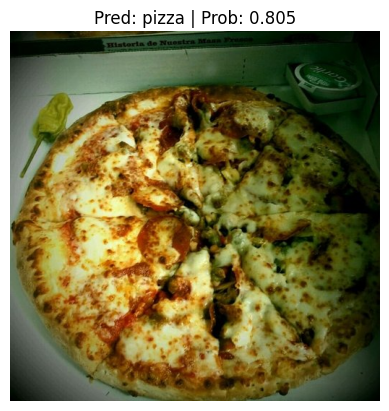

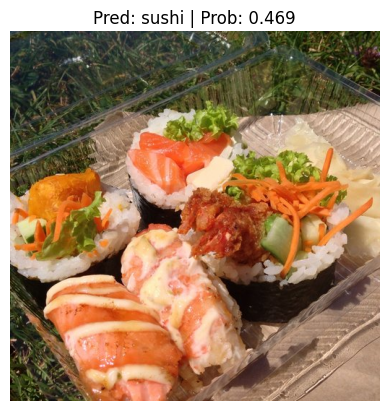

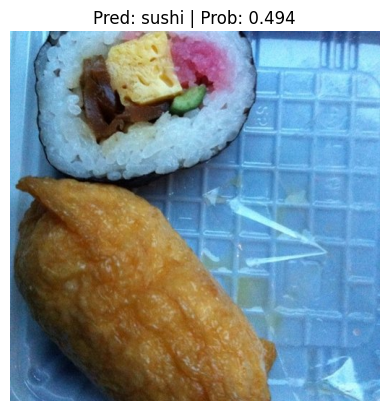

In [15]:
# Test Setinden rastgele görsel al.
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # test_data'dan resim al.
test_image_path_sample = random.sample(population=test_image_path_list, # yolu belirle
                                       k=num_images_to_plot) # rastgele değer ata

# Tahmin yap ve görselleştir.
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # şimdilik weights'e bakmayacağız.
                        image_size=(224, 224))